Import package + model

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import (
    load_json_model,
    save_json_model,
    load_matlab_model,
    save_matlab_model,
    read_sbml_model,
    write_sbml_model,
)
from cobra.flux_analysis import flux_variability_analysis
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
M_xanthus = read_sbml_model("../M_xanthus_model.sbml")
M_xanthus

Name,myxo_model
Memory address,7a836590fe00
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [6]:
E_coli = load_json_model("../E_coli_model.json")
E_coli

Name,iML1515
Memory address,730a1ddb2710
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**COBRApy implementation**

In [ ]:
##COBRApy
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species (Can put more)
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with E_coli:
        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            E_coli,
            [
                "BIOMASS_Ec_iML1515_core_75p37M",
                "EX_glc__D_e",
            ],
            ["max", "max"],
        )

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description("t = {:.3f}".format(t))

    return fluxes


dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with E_coli:

        add_dynamic_bounds(E_coli, y)

        cobra.util.add_lp_feasibility(E_coli)
        feasibility = cobra.util.fix_objective_as_constraint(E_coli)

    return feasibility - infeasible_event.epsilon


infeasible_event.epsilon = 1e-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 10, 20)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method="BDF",
    )

0it [00:00, ?it/s]

t = 0.000: : 5it [00:06,  1.25s/it]


KeyboardInterrupt: 

In [101]:
sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  5.263e-01  1.053e+00  1.579e+00  2.105e+00
             2.632e+00  3.158e+00  3.684e+00  4.211e+00  4.737e+00
             5.263e+00]
        y: [[ 1.000e-01  1.620e-01 ...  1.479e+00  1.483e+00]
            [ 1.000e+01  9.552e+00 ...  3.738e-02  7.906e-03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 805
     njev: 29
      nlu: 238

**My code**

In [ ]:
E_coli.reactions.EX_ac_e  # not used in model
E_coli.reactions.EX_etoh_e  # not used in model
E_coli.reactions.EX_for_e  # not used in model

Reaction identifier,EX_k_e
Name,K+ exchange
Memory address,0x75da2d010b90
Stoichiometry,k_e <=> Potassium <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [7]:
t = 0
tf = 50
steps = 1
time_point = [0]
it = 1
y = [10, 10, 10, 10, 10, 10, 10, 10, 10]
fluxes_E = []

reactions_list_E_coli = []
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)


def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose. \n
    :param model model: The model you want to add dynamic bounds. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, iron3, iron2, copper, amonium, sulfate, phosphate, potassium.
    """
    glucose, oxygen, iron3, iron2, copper, ammonium, sulfate, phosphate, potassium = (
        y  # expand the boundary species (Can put more)
    )

    glucose_max_import = (
        -10 * glucose / (5 + glucose)
    )  # calculate the max import value for the metabolites
    oxygen_max_import = -10 * oxygen / (5 + oxygen)
    iron3_max_import = -10 * iron3 / (5 + iron3)
    iron2_max_import = -10 * iron2 / (5 + iron2)
    copper_max_import = -10 * copper / (5 + copper)
    ammonium_max_import = -10 * ammonium / (5 + ammonium)
    sulfate_max_import = -10 * sulfate / (5 + sulfate)
    phosphate_max_import = -10 * phosphate / (5 + phosphate)
    potassium_max_import = -10 * potassium / (5 + potassium)

    model.reactions.EX_glc__D_e.lower_bound = (
        glucose_max_import  # change the limit of importation with the mex import
    )
    model.reactions.EX_o2_e.lower_bound = oxygen_max_import
    model.reactions.EX_fe3_e.lower_bound = iron3_max_import
    model.reactions.EX_fe2_e.lower_bound = iron2_max_import
    model.reactions.EX_cu2_e.lower_bound = copper_max_import
    model.reactions.EX_nh4_e.lower_bound = ammonium_max_import
    model.reactions.EX_so4_e.lower_bound = sulfate_max_import
    model.reactions.EX_pi_e.lower_bound = phosphate_max_import
    model.reactions.EX_k_e.lower_bound = potassium_max_import


def update_metabolites(fluxes, y):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(int) fluxes: The list of the fluxes. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, iron3, iron2, copper, amonium, sulfate, phosphate, potassium.
    """
    glucose, oxygen, iron3, iron2, copper, ammonium, sulfate, phosphate, potassium = (
        y  # expand the boundary species (Can put more)
    )

    glucose = glucose + fluxes["EX_glc__D_e"]  # calculate the number of metabolites
    oxygen = oxygen + fluxes["EX_o2_e"]
    iron3 = iron3 + fluxes["EX_fe3_e"]
    iron2 = iron2 + fluxes["EX_fe2_e"]
    copper = copper + fluxes["EX_cu2_e"]
    ammonium = ammonium + fluxes["EX_nh4_e"]
    sulfate = sulfate + fluxes["EX_so4_e"]
    phosphate = phosphate + fluxes["EX_pi_e"]
    potassium = potassium + fluxes["EX_k_e"]

    y = (
        glucose,
        oxygen,
        iron3,
        iron2,
        copper,
        ammonium,
        sulfate,
        phosphate,
        potassium,
    )  # changing the value of the metabolites
    return y


with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(E_coli, y)
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(
            reactions_list_E_coli
        )  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        time_point.append(time_point[it - 1] + steps)  # store the time point
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        y = update_metabolites(fluxes_E_coli, y)
        it += 1
        t += steps
        pbar.update(steps)

100%|██████████| 50/50 [00:05<00:00,  9.64it/s]


In [67]:
exchanges = []
for i in E_coli.exchanges:
    exchanges.append(i.id)

imported = []
for j in exchanges:
    if fluxes_E[0][j] < 0 and fluxes_E[0][j] < -0.01:
        print(j + ": " + str(fluxes_E[0][j]))
        imported.append(j)
len(imported)

EX_pi_e: -0.05954404888064024
EX_glc__D_e: -0.6666666666666667
EX_so4_e: -0.015544566785942245
EX_nh4_e: -0.6666666666666667
EX_k_e: -0.012049045447734162
EX_o2_e: -0.10677334253082629


6

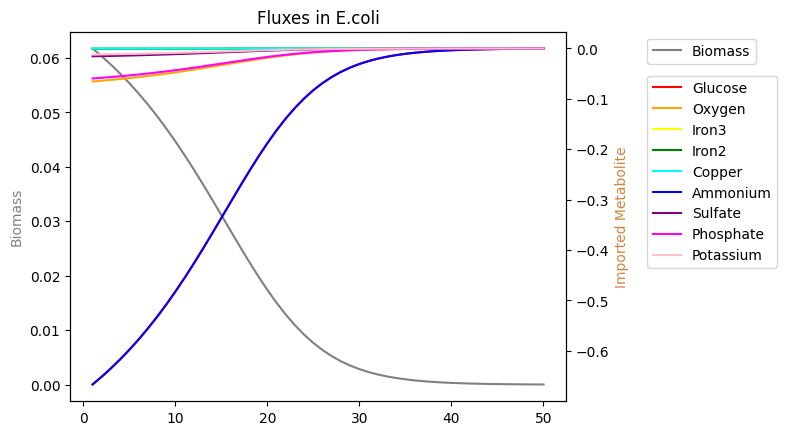

In [8]:
glucose = []
oxygen = []
iron3 = []
iron2 = []
copper = []
ammonium = []
sulfate = []
phosphate = []
potassium = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    oxygen.append(i["EX_o2_e"])
    iron3.append(i["EX_fe3_e"])
    iron2.append(i["EX_fe2_e"])
    copper.append(i["EX_cu2_e"])
    ammonium.append(i["EX_nh4_e"])
    sulfate.append(i["EX_so4_e"])
    phosphate.append(i["EX_pi_e"])
    potassium.append(i["EX_k_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="gray", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], iron3, color="yellow", label="Iron3")
ax2.plot(time_point[1:], iron2, color="green", label="Iron2")
ax2.plot(time_point[1:], copper, color="cyan", label="Copper")
ax2.plot(time_point[1:], ammonium, color="blue", label="Ammonium")
ax2.plot(time_point[1:], sulfate, color="purple", label="Sulfate")
ax2.plot(time_point[1:], phosphate, color="magenta", label="Phosphate")
ax2.plot(time_point[1:], potassium, color="pink", label="Potassium")

ax.set_ylabel("Biomass", color="gray")
ax2.set_ylabel("Imported Metabolite", color="peru")

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")